# DETR - Training and Evaluation

This notebook contains the code and commands to train and evaluate the results of the DETR algorithm.

You can either download a [pretrained model](https://drive.google.com/file/d/1TB7vYB7PmeyE_ryDhrczXNZujgK-4uKG/view?usp=sharing) or run the following commands to train it yourself.

To run the pretrained model just download the .pth file and place it in the DETR/ directory.

To train the model yourself simply run the following commands.

In [ ]:
!pip3 install -r requirements.txt

The following command will train the DETR model with arguments set to sensible defaults. Here are some optional arguments:
- -b
    * Specify the batch size. The optimal value is usually around double the number of GPU cores on your machine.
- -e
    * Specify the number of epochs
- --cuda
    * Include this flag to enable training on the GPU.

This may take many hours. The script will save each epoch if it performs better than the previous epoch and will save the model in the DETR directory.

In [2]:
!python3 train.py -b 8 -e 500 --cuda

Using hardware acceleration
/home/jamie/cs9517/HighDefinition/DETR
Training face_detr with batch_size=8

Using cache found in /home/jamie/.cache/torch/hub/facebookresearch_detr_main
/home/jamie/cs9517/opencv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jamie/cs9517/opencv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|███████████████████████████████| 9/9 [00:00<00:00, 10.85it/s, loss=1.33e+3]
|EPOCH 1| TRAIN_LOSS 1332.7449951171875| VALID_LOSS 1325.9341634114583|
Best model f

### DETR Result Visualisation

The following code is used to evaluate the results of a trained DETR model. It loads the trained model and a random image and displays the bounding box on the image as a sanity check. It will then compute some metrics about the model such as precision.

In [3]:
import os
import numpy as np 
#import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm
from argparse import ArgumentParser


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

# Dataloader
from dataset import CustomImageDataset

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
import os
print(os.getcwd())
# The python interpreter is dumb so we need to change directories
sys.path.insert(0, os.getcwd() + 'facebook_DETR/')
sys.path.insert(0, os.getcwd() + 'facebook_DETR/detr/')

print(sys.path)

from detr.models.matcher import HungarianMatcher
#from detr import SetCriterion
#################################################################

#Albumenatations
#import albumentations as A
%matplotlib inline
import matplotlib.pyplot as plt
#from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

from train_detr import DETRModel, collate_fn

/tmp/ipykernel_31134/3572071234.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


/home/jamie/cs9517/HighDefinition/DETR
['/home/jamie/cs9517/HighDefinition/DETRfacebook_DETR/detr/', '/home/jamie/cs9517/HighDefinition/DETRfacebook_DETR/', '/home/jamie/cs9517/HighDefinition/DETR', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/jamie/cs9517/opencv/lib/python3.10/site-packages']


In [4]:
valid_dataset = CustomImageDataset('../images/valid', annotation_path="../images/valid_annotations", transforms=None)
valid_dataloader = DataLoader(valid_dataset, 
                                batch_size=1, 
                                shuffle=True,
                                collate_fn=collate_fn)

device = "cpu"

n_folds = 5
seed = 42
num_classes = 2 # Penguin or turtle
num_queries = 1 # Only one in image but if there are multiple we can increment this
null_class_coef = 0.5
BATCH_SIZE = 1
LR = 2e-5
EPOCHS = 1000

#### Sanity Check

The following code creates an instance of the DETR model and loads the weights from a filename specified in path. It will then display an image with the bounding boxes drawn on top as a sanity check. However, as the model fails to train effectively the box is 1x1 pixel and not easily visible.

Using cache found in /home/jamie/.cache/torch/hub/facebookresearch_detr_main
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


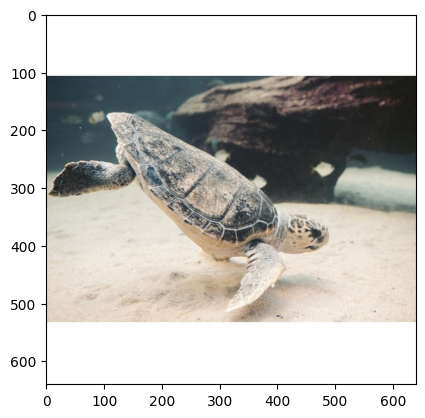

tensor([[[-6.6957,  7.1561],
         [-6.6355,  7.0641],
         [-6.5813,  7.1436],
         [-6.7147,  7.0447],
         [-6.5870,  7.0276],
         [-6.3932,  7.2791],
         [-6.7281,  6.9555],
         [-6.6499,  6.9601],
         [-6.5305,  7.1478],
         [-6.7334,  6.8742],
         [-6.4490,  7.1809],
         [-6.5740,  6.9954],
         [-6.6593,  6.8474],
         [-6.6510,  6.9087],
         [-6.6794,  6.9106]]])


In [7]:
path = "detr_best_456.pth"

model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load(path))

images, targets = next(iter(valid_dataloader))

images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

with torch.no_grad():
    outputs = model(images)

outputs = [{k: v.to("cpu") for k, v in outputs.items()}]

sample = images[0].cpu().permute(1, 2, 0).numpy()

for box in outputs[0]["pred_boxes"][0]:
    #print(sample)
    box = box.numpy().astype(int)
    # This draws the bounding box but since it has a height and width of 1 it is very hard
    # to see
    cv2.rectangle(sample,
                (box[0], box[1]),
                (box[2]+box[0], box[3]+box[1]),
                (220, 0, 0), 1)

plt.imshow(sample)
plt.show()

max_out = outputs[0]["pred_logits"].softmax(-1).max(-1)
topk = max_out.values.topk(15)
print(outputs[0]["pred_logits"][0, topk.indices, :])

In [8]:
import math

'''
Some helper functions
'''
def compute_iou(x1, y1, w1, h1, x2, y2, w2, h2):
    # Calculate the (x, y)-coordinates of the intersection rectangle
    inter_top_left_x = max(x1, x2)
    inter_top_left_y = max(y1, y2)
    inter_bottom_right_x = min(x1 + w1, x2 + w2)
    inter_bottom_right_y = min(y1 + h1, y2 + h2)
    
    inter_area = max(0, inter_bottom_right_x - inter_top_left_x) * max(0, inter_bottom_right_y - inter_top_left_y)

    # Compute the area of both the prediction and ground-truth rectangles
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the intersection area
    iou = inter_area / float(box1_area + box2_area - inter_area)

    # return the intersection over union value
    return iou

def calculate_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [9]:
target_class_list = []
output_class_list = []
iou_list = []
distance_list = []

for image, targets in valid_dataloader:
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        outputs = model(images)

    target_class_list.append(targets[0]["labels"][0])
    if outputs["pred_logits"][0][0,0] > outputs["pred_logits"][0][0,1]:
        output_class_list.append(0)
        print("found one")
    else:
        output_class_list.append(1)

    x1, y1, w1, h1 = targets[0]["boxes"][0,:].numpy()
    x2, y2, w2, h2 = outputs["pred_boxes"][0,0,:].numpy()
    iou_list.append(compute_iou(x1, y1, w1, h1, x2, y2, w2, h2))
    distance_list.append(calculate_distance(x1, y1, x2, y2))

#### Results

The following code computes some metrics about the models effectiveness. We see it almost completely fails the classification task and only receives a precision of 0.5 for the penguin class as it labels every image as a penguin.

Additionally, the model always produces a bounding box at the coordinates (1, 1) with a height and width of 1 pixel. As a result the model never correctly locates the animal in each image and achieves an iou score of zero on every image.

In [10]:
from sklearn import metrics
from sklearn.metrics import classification_report

print(classification_report(target_class_list, output_class_list, target_names=["turtle", "penguin"]))

print(f"iou_mean: {np.mean(iou_list)}")
print(f"iou_std: {np.std(iou_list)}")

print(f"distance mean: {np.mean(distance_list)}")
print(f"distance std: {np.std(distance_list)}")

              precision    recall  f1-score   support

      turtle       0.00      0.00      0.00        36
     penguin       0.50      1.00      0.67        36

    accuracy                           0.50        72
   macro avg       0.25      0.50      0.33        72
weighted avg       0.25      0.50      0.33        72

iou_mean: 0.0
iou_std: 0.0
distance mean: 260.0058126336428
distance std: 82.31131998115188


/home/jamie/cs9517/opencv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jamie/cs9517/opencv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jamie/cs9517/opencv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
